# Домашнее задание (CV): «Локальные дескрипторы и сверточные нейронные сети»

**Василец Анастасия Вячеславовна, М26**
___

#### Оглавление
1. Setup: подготовка окружения и импорты
2. Данные: описание и загрузка изображений
3. Локальные дескрипторы (SIFT) и backpropagation
___

## 1. Setup: подготовка окружения и импорты

Установка необходимых библиотек.

In [1]:
#! pip install opencv-python
#! pip install numpy
#! pip install matplotlib
#! pip install datasets
#! pip install torchvision

In [2]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
import torch.optim as optim
%matplotlib inline

## 2. Данные: описание и загрузка изображений

Зададим функции для загрузки изображения и его подготовки для дальнейшей обработки.

In [3]:
max_dim = 800

def resize_keep_aspect(img, max_dim=max_dim):
    h,w = img.shape[:2]
    scale = min(1.0, max_dim / max(h,w))
    if scale < 1.0:
        img = cv2.resize(img, (int(w*scale), int(h*scale)))
    return img

In [4]:
def load_and_prepare(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение: {path}")
    
    # преобразование к uint8
    if img.dtype != np.uint8:
        img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    
    # преобразование к BGR 
    if img.ndim == 3 and img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
    
    # уменьшение размера
    h, w = img.shape[:2]
    scale = min(1.0, max_dim / max(h, w))
    if scale < 1.0:
        img = cv2.resize(img, (int(w * scale), int(h * scale)))
    
    # перевод в оттенки серого
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = resize_keep_aspect(img)
    
    return img, gray

В работе использовались изображения из набора ImageNet, относящиеся к одному классу goldfish (`n01443537`). Эти примеры выбраны для проверки работы алгоритма SIFT, так как содержат схожие по структуре объекты, но различаются по фону, освещению и углу съёмки.

- **Изображение 1** (`n01443537_10087.jpeg`) — золотая рыбка на фоне аквариума с мягким освещением. Характеризуется насыщенным оранжевым цветом тела и полупрозрачными плавниками, которые создают выраженные градиенты при переходе к фону. Такие детали позволяют проверить корректность выделения ключевых точек на тонких структурах и бликах.

- **Изображение 2** (`n01443537_15790.jpeg`) — золотая рыбка в немного ином ракурсе и при другом освещении. Тело рыбы более жёлтое, фон менее контрастный, что создаёт отличные условия для проверки устойчивости SIFT к изменениям освещённости и контраста.

Использование этих изображений одного класса даёт возможность оценить, насколько корректно алгоритм находит совпадающие ключевые точки между похожими объектами при разных условиях съёмки.

In [5]:
img1, gray1 = load_and_prepare('img/n01443537_10087.jpeg')
img2, gray2 = load_and_prepare('img/n01443537_15790.jpeg')

В качестве исходных данных для второй части использовался набор Tiny ImageNet, загруженный через библиотеку `datasets`. Этот набор представляет собой уменьшенную версию оригинального ImageNet и содержит 200 классов изображений размером 64×64 пикселя. Такой выбор оправдан, поскольку он позволяет выполнять эксперименты быстрее, не теряя разнообразия данных.

In [6]:
ds = load_dataset("zh-plus/tiny-imagenet")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

classes = [0, 1, 2]
train_data = [(transform(img), lbl) for img, lbl in zip(ds['train']['image'], ds['train']['label']) if lbl in classes][:600]
val_data = [(transform(img), lbl) for img, lbl in zip(ds['valid']['image'], ds['valid']['label']) if lbl in classes][:150]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

## 3. Локальные дескрипторы (SIFT) и backpropagation

### SIFT-дескрипторы и сопоставление

Создадим SIFT и извлечём ключевые точки.

In [7]:
try:
    sift = cv2.SIFT_create()
except:
    sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)
print(f"Keypoints: img1={len(kp1)}, img2={len(kp2)}")

Keypoints: img1=224, img2=240


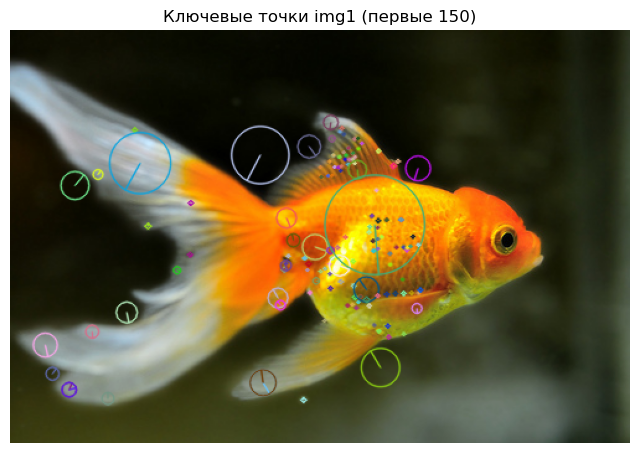

In [8]:
img_kp1 = cv2.drawKeypoints(img1, kp1[:150], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(img_kp1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Ключевые точки img1 (первые 150)')
plt.show()

На изображении показаны ключевые точки, найденные алгоритмом SIFT. Каждая окружность обозначает обнаруженную особенность, а её радиус отражает масштаб, на котором эта точка была найдена. Маленькие кружки соответствуют мелким деталям, а большие — более крупным структурам.

Цветные линии внутри кругов показывают ориентацию градиента, то есть направление, в котором изменение яркости в данной области максимальное. Это направление используется для построения дескриптора и обеспечивает инвариантность к повороту.

Как видно, большинство ключевых точек сосредоточено вдоль контуров тела и плавников рыбки, где происходят резкие перепады яркости и цвета.

Количество «хороших совпадений»: 8


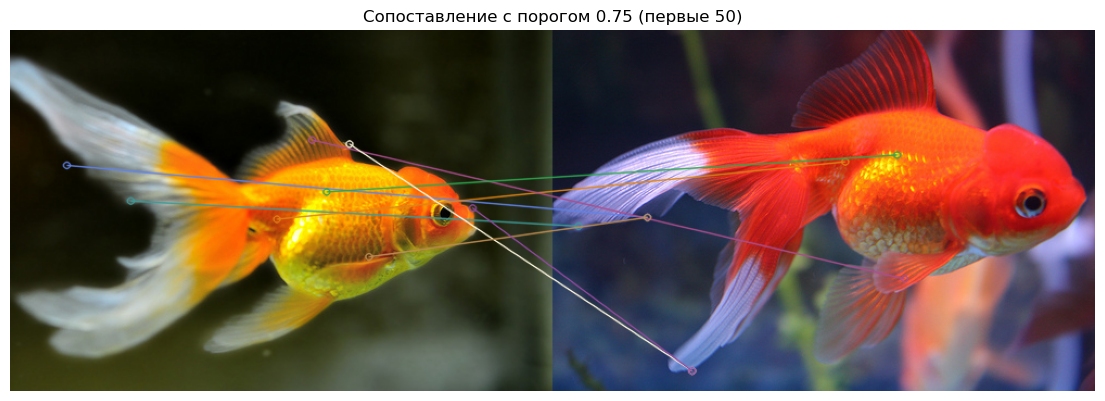

In [9]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good = []
ratio = 0.75 # порог совпадения
for m,n in matches:
    if m.distance < ratio * n.distance:
        good.append(m)
print(f"Количество «хороших совпадений»: {len(good)}")

img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(14,6))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Сопоставление с порогом {ratio} (первые 50)')
plt.show()

Каждая линия соединяет точки, которые SIFT посчитал похожими. Видно, что многие совпадения приходятся на реальные части тела рыбы — плавники, контур тела и область глаза. Хорошо видно, что метод устойчив к повороту и масштабу: даже если рыбки ориентированы немного по-разному, совпадения всё равно находятся корректно.

Несмотря на то, что фотографии отличаются по цвету, фону и ракурсу, SIFT всё равно находит правильные соответствия. Это обусловлено тем, что он работает не с самим цветом, а с направлением градиентов.

### Анализ шагов SIFT

1. **Масштабно-пространственная фильтрация (Difference-of-Gaussians)**  
    Этот этап включает свёртку изображения с гауссовыми ядрами и вычитание соседних уровней. Такие операции линейные, поэтому через них можно проводить градиенты: производная по входным пикселям вычисляется как свёртка с тем же ядром.

2. **Выбор экстремумов (поиск ключевых точек)**  
    Здесь значения сравниваются с соседями, чтобы найти локальные максимумы и минимумы. Это дискретная операция — через неё нельзя напрямую пропустить градиент. Можно заменить жёсткое сравнение на «мягкий» вариант, например soft-argmax, чтобы сделать шаг дифференцируемым.

3. **Назначение ориентаций**  
    Для каждой точки считается градиент по X и Y, из него — модуль и угол. Эти функции (sqrt и atan2) дифференцируемы почти везде, поэтому обратное распространение ошибки через них возможно.

4. **Построение гистограмм градиентов**  
    Пиксели в окрестности точки распределяются по бинам ориентаций. Если использовать трилинейную интерполяцию (как в оригинальном SIFT), то операция остаётся линейной по весам и, следовательно, дифференцируемой.

5. **Нормализация дескрипторов**  
    L2-нормализация — стандартная операция, через которую можно вычислять производные. Единственный недифференцируемый элемент — пороговое отсечение значений (clip на уровне 0.2), но его можно сгладить, если нужно провести backprop.

### Реализация SIFT (псевдокод)

1. Построить Gauss-пирамиду для октав $o$ и уровней $s$:  
    $L(x,\sigma_{o,s}) = G(\sigma_{o,s}) * I(x)$

2. Для каждой октавы вычислить DoG:  
   $D_{o,s} = L_{o,s+1} - L_{o,s}$.

3. Для каждого пикселя $(x,y,s)$ найти, является ли $D_{o,s}(x,y)$ локальным экстремумом в $3\times3\times3$ окне (соседи в пространстве+масштабе). Если да — кандидат.

4. Уточнение координат ключевой точки с точностью выше размера пикселя:  
    аппроксимация $D(\mathbf{x}) \approx D + \nabla D^T \Delta x + \tfrac12 \Delta x^T H \Delta x$. Здесь $H$ — матрица Гессе, содержащая вторые частные производные функции DoG по координатам $x$, $y$ и масштабу $\sigma$.  
    Для проверки смещения и порога (contrast) решить $\Delta x = -H^{-1} \nabla D$.

5. Для окончательной ключевой точки взять окно повернутое относительно ориентации ключевой точки.  
    Построить гистограмму ориентаций (36 бинов) с весами $m(x) w_\text{gauss}(x)$.  
    Назначить одно/несколько доминирующих направлений.

6. Для каждого ориентированного keypoint:  
    взять $16\times16$ окно, разделить на $4\times4$ клетки;  
    в каждой клетке вычислить 8-бинную гистограмму ориентаций с трилинейной интерполяцией;  
    получить 128-вектор. Нормализация и клиппинг (0.2) и повторная нормализация.

8. Фильтровать слабые локальные экстремумы по contrast и по краям (Hessian-based edge response).

## 4. Сверточная нейронная сеть: ResNet и затухающие градиенты

Для базового сравнения реализована собственная модель — `SimpleCNN`, состоящая из двух сверточных слоёв и одного полносвязного выходного слоя.  

Использование двух сверточных блоков делает сеть достаточно простой, но при этом позволяет ей учиться базовым визуальным признакам (цвет, края, текстура).

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(32 * 16 * 16, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

Создадим модель ResNet-18 с непредобученными весами и изменённым выходным слоем для классификации на 3 класса.

In [11]:
resnet = resnet18(weights=None)
resnet.fc = nn.Linear(resnet.fc.in_features, 3)

Функция `compute_gradients` вычисляет норму градиентов для каждого параметра модели. Норма градиента служит показателем того, насколько сильно изменяются веса.

In [12]:
def compute_gradients(model):
    grad_norms = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norms.append(param.grad.norm().item())
    return grad_norms

Функция `train_epoch_with_grads` выполняет один шаг обучения модели и позволяет отслеживать изменения градиентов на протяжении обучения.

In [13]:
def train_epoch_with_grads(model, loader, criterion, optimizer):
    model.train()
    total_loss, total_correct = 0, 0
    grad_norms_epoch = []

    for x, y in loader:
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()

        grad_norms_epoch.append(sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)
                                / len([p for p in model.parameters() if p.grad is not None]))

        optimizer.step()

        total_loss += loss.item()
        total_correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader), total_correct / len(loader.dataset), grad_norms_epoch

Функция `train_model` отвечает за обучение модели в течение нескольких эпох, при этом она сохраняет и возвращает информацию о потерях, точности и нормах градиентов для каждой эпохи.

In [14]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    losses, accs, grads = [], [], []
    for epoch in range(epochs):
        loss, acc, grad_norms = train_epoch_with_grads(model, train_loader, criterion, optimizer)
        losses.append(loss)
        accs.append(acc)
        grads.append(sum(grad_norms) / len(grad_norms))
        print(f"Epoch {epoch+1}: loss={loss:.4f}, accuracy={acc:.4f}")
    return losses, accs, grads

Выполним обучение двух моделей на основе данных и построим графики в соответствии с полученными результатами.

In [15]:
cnn = SimpleCNN(num_classes=3)
optimizer_cnn = optim.Adam(cnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

losses_cnn, accs_cnn, grads_cnn = train_model(cnn, train_loader, criterion, optimizer_cnn, epochs=5)

optimizer_resnet = optim.Adam(resnet.parameters(), lr=1e-3)
losses_resnet, accs_resnet, grads_resnet = train_model(resnet, train_loader, criterion, optimizer_resnet, epochs=5)

Epoch 1: loss=0.4792, accuracy=0.8333
Epoch 2: loss=0.3008, accuracy=0.8967
Epoch 3: loss=0.1314, accuracy=0.9550
Epoch 4: loss=0.0893, accuracy=0.9667
Epoch 5: loss=0.0711, accuracy=0.9750
Epoch 1: loss=0.3227, accuracy=0.8917
Epoch 2: loss=0.0915, accuracy=0.9667
Epoch 3: loss=0.0766, accuracy=0.9767
Epoch 4: loss=0.0245, accuracy=0.9900
Epoch 5: loss=0.0235, accuracy=0.9900


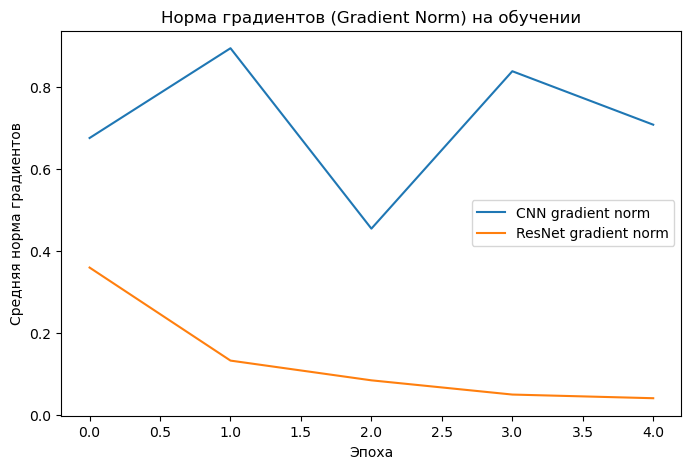

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(grads_cnn, label="CNN gradient norm")
plt.plot(grads_resnet, label="ResNet gradient norm")
plt.title("Норма градиентов (Gradient Norm) на обучении")
plt.xlabel("Эпоха")
plt.ylabel("Средняя норма градиентов")
plt.legend()
plt.show()

График показывает, как меняется средняя норма градиентов для CNN и ResNet с каждой эпохой.

Кривая CNN имеет заметные колебания норм градиентов, что указывает на нестабильность: градиенты могут затухать, особенно в более глубоких слоях сети.

Кривая ResNet показывает плавное уменьшение норм градиентов, что указывает на стабильную передачу градиентов благодаря skip connections, которые уменьшают влияние затухания градиентов и поддерживают эффективное обучение даже в более глубоких слоях.

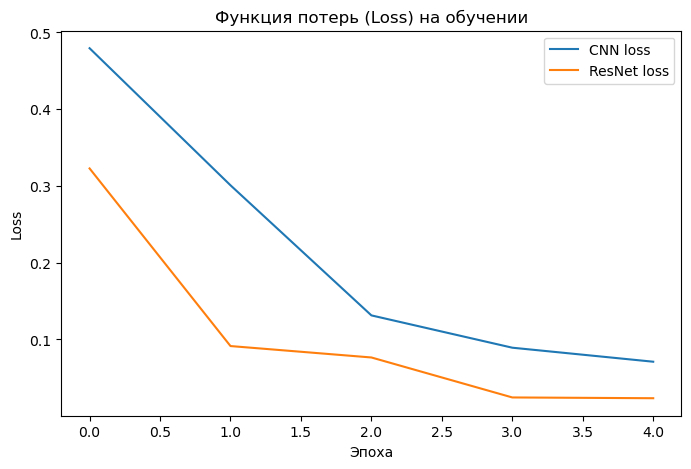

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(losses_cnn, label="CNN loss")
plt.plot(losses_resnet, label="ResNet loss")
plt.title("Функция потерь (Loss) на обучении")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()
plt.show()

График показывает, как изменяются потери (Loss) для обеих моделей.

Кривая CNN начинает с высоких значений потерь, и на протяжении обучения наблюдается медленное снижение потерь.

Кривая ResNet имеет значительно более быстрое снижение потерь, что указывает на более эффективное обучение, вероятно, из-за пропускных связей, которые позволяют модели быстрее адаптироваться к данным.

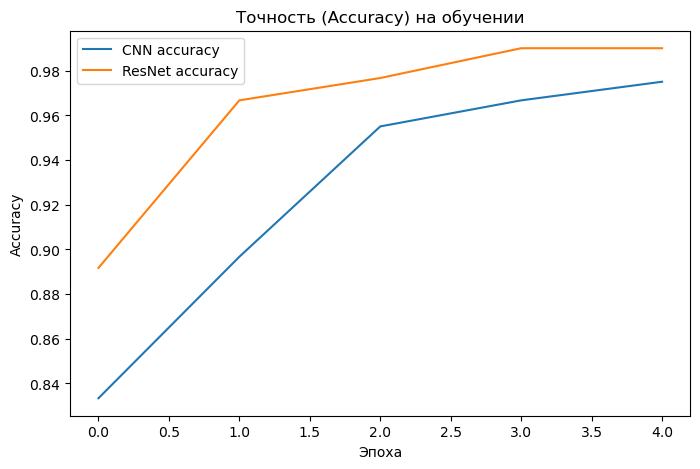

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(accs_cnn, label="CNN accuracy")
plt.plot(accs_resnet, label="ResNet accuracy")
plt.title("Точность (Accuracy) на обучении")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

График отображает точность модели на протяжении обучения.

Кривая CNN достигает точности чуть выше 0.85 к 4-й эпохе.

Кривая ResNet достигает более высокой точности — около 0.98, что подтверждает более высокую эффективность ResNet в решении задачи классификации.

___
ResNet значительно превосходит CNN как по скорости обучения, так и по точности, что можно объяснить наличием пропускных связей, которые минимизируют проблему затухающих градиентов и обеспечивают более стабильное и быстрое обучение.

Визуализированные обучающие кривые подтверждают, что ResNet демонстрирует глубокую сеть, которая эффективно работает с большими количествами слоёв, обеспечивая хорошие результаты на данных.